In [51]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Imports and utils

In [52]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from io import StringIO, BytesIO
import numpy as np
import IPython.display
import PIL.Image

tf.compat.v1.enable_eager_execution()
tf.compat.v1.enable_v2_behavior()

In [53]:
#@title Plotting utilities
# Plotting utils, taken from
# https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb
def imgrid(imarray, cols=5, pad=1):
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant')
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  return grid[:-pad, :-pad]

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  png_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(png_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

# Setup: Model and data

Set the `HUB_PATH` variable to point to the hub module, e.g. `/home/username/yoto_xyz/hub_modules/step-000550000`.

In [78]:
#@title Module path and constants
HUB_PATH = None  # Set this variable, see comment above.
DATASET_NAME = "shapes3d"  # Either shapes3d or cifar10.
BATCH_SIZE = 10

# The configs distributed with this package, differ in that for cifar10 the input
# is scaled to [-1. 1] and there is no sigmoid-transform, while for shapes3 the
# range is scaled to [0, 1] and a logit transofrm is used.
if DATASET_NAME == "cifar10":
  RANGE = "-1_1"
  SIGMOID = False
else:
  RANGE = "0_1"
  SIGMOID = True

In [79]:
def postprocess(images):
  if SIGMOID:
    images = tf.nn.sigmoid(images)
  if RANGE == "-1_1":
    images = (1 + images) / 2  # [-1, 1] to [0, 1]
  images = tf.clip_by_value(images * 255, 0, 255)
  return tf.cast(images, tf.uint8)

In [80]:
#@title Load the data form tfds
def data_reader():
  dataset = tfds.load(DATASET_NAME, split="train")
  for data in dataset.batch(BATCH_SIZE):
    images_np_int = data["image"].numpy()
    images_np = images_np_int.astype(np.float) / 255
    if RANGE == "-1_1":
      images_np = 2 * images_np - 1
    yield images_np, images_np_int

In [81]:
#@title Load the VAE.

spec = hub.load_module_spec(HUB_PATH)
noise_dim = spec.get_input_info_dict("sample")["noise"].get_shape()[1]
imsize, channels = spec.get_output_info_dict(
    "sample")["default"].get_shape()[-2:]


sampler = hub.KerasLayer(HUB_PATH, signature="sample")
def sample(noise_np, beta=0.): 
    inputs_extra_np = np.log(
        np.stack([np.ones(BATCH_SIZE) * beta, np.ones(BATCH_SIZE) * 1.],
                 axis=1)).astype(np.float)
    return postprocess(
        sampler({"noise": noise_np, "inputs_extra": inputs_extra_np}))

reconstructor = hub.KerasLayer(HUB_PATH, signature="reconstruct")
def reconstruct(images_np, beta=0.):
    inputs_extra_np = np.log(
        np.stack([np.ones(BATCH_SIZE) * beta, np.ones(BATCH_SIZE) * 1.],
                 axis=1)).astype(np.float)
    return postprocess(
        reconstructor({"image": images_np, "inputs_extra": inputs_extra_np}))

# Plotting

In [82]:
reader = data_reader()  # Initialize the data reader.

In [83]:
np.random.seed(18)
noise_np = np.random.randn(BATCH_SIZE, noise_dim) * 1.
images_np, images_np_int = next(reader)   # Fetch the first batch.

Reconstructions:


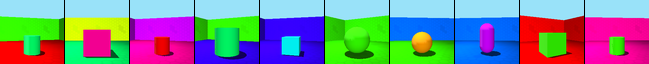

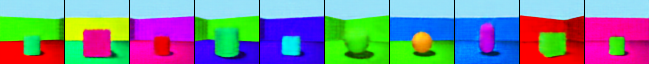

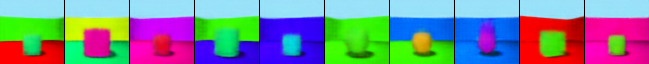

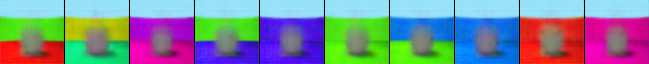

Samples:


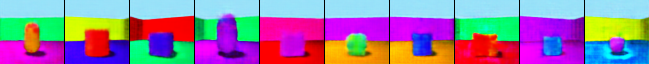

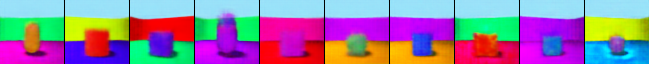

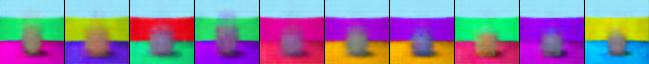

In [84]:
beta_values = [1, 128, 512]

print("Reconstructions:")

input_grid = imgrid(images_np_int, cols=BATCH_SIZE)
imshow(input_grid)

for beta in beta_values:
  reconstructions = reconstruct(images_np, beta)
  recon_grid = imgrid(reconstructions.numpy(), cols=BATCH_SIZE)
  imshow(recon_grid)

print("Samples:")

for beta in beta_values:
  sample_grid = imgrid(sample(noise_np, beta).numpy(), cols=BATCH_SIZE)
  imshow(sample_grid)